In [31]:
import numpy as np
import matplotlib.pyplot as plt
# from time import time
import time
from mpl_toolkits.mplot3d import Axes3D
import math

# from cmd_manager.hyperdog_variables import Body, Leg, Cmds





class GaitPlanner():
    def __init__(self, cmd, leg):
        self.cmd = cmd
        self.leg = leg
        # self.body = body

        self.gnd_touched = np.ones([4]) #fr,fl,br,bl
        self.sample_time = 0.005

        self.FR_traj = np.zeros([3])
        self.FL_traj = np.zeros([3])
        self.BR_traj = np.zeros([3])
        self.BL_traj = np.zeros([3])

        self.fr_traj = []
        self.fl_traj = []
        self.br_traj = []
        self.bl_traj = []


    def swing_FR(self, t):
        traj_pnt = np.zeros([3])
        self.leg.FR.gait.swing.time =  self.cmd.gait.swing_time
        if self.cmd.mode.walk:
            self.leg.FR.gait.swing.end_pnt[:2] = np.array(self.cmd.gait.step_len)/2
            self.leg.FR.gait.swing.end_pnt[2] = self.leg.FR.pose.cur_coord[2]
            # set start point
            if self.leg.FR.gait.swing.start == False:
                self.leg.FR.gait.swing.start = True
                self.leg.FR.gait.swing.start_pnt[:2] = self.leg.FR.pose.cur_coord[:2] - self.cmd.leg.foot_zero_pnt[0,:2]
                self.leg.FR.gait.swing.start_pnt[2] = self.leg.FR.pose.cur_coord[2]
            # make trajectory
            T = self.leg.FR.gait.swing.time
            
            traj_pnt[:2] = self.leg.FR.gait.swing.start_pnt[:2] + (self.leg.FR.gait.swing.end_pnt[:2] - self.leg.FR.gait.swing.start_pnt[:2])*t/T 
            traj_pnt[2] = - np.array(self.cmd.gait.swing_step_h)* np.sin(t/T*np.pi)
            # end point
            if t >= T - self.sample_time*2:
                traj_pnt[:2] = np.array(self.leg.FR.gait.swing.end_pnt)[:2]
                traj_pnt[2] = 0
                self.leg.FR.gait.swing.start = False
        else:
            traj_pnt[:2] = self.leg.FR.pose.cur_coord[:2] - self.cmd.leg.foot_zero_pnt[0,:2]
            traj_pnt[2] = 0
        self.FR_traj = np.array(traj_pnt)
        return self.FR_traj

    def stance_FR(self, t):
        traj_pnt = np.zeros([3])
        self.leg.FR.gait.stance.time = self.cmd.gait.cycle_time - self.cmd.gait.swing_time
        if self.cmd.mode.walk:
            self.leg.FR.gait.stance.end_pnt[:2] = - np.array(self.cmd.gait.step_len)/2
            self.leg.FR.gait.stance.end_pnt[2] = self.leg.FR.pose.cur_coord[2]
            # set start point
            if self.leg.FR.gait.stance.start == False:
                self.leg.FR.gait.stance.start = True
                self.leg.FR.gait.stance.start_pnt[:2] = self.leg.FR.pose.cur_coord[:2] - self.cmd.leg.foot_zero_pnt[0,:2]
                self.leg.FR.gait.stance.start_pnt[2] = self.leg.FR.pose.cur_coord[2]
            # make trajectory
            
            T = self.leg.FR.gait.stance.time
            traj_pnt[:2] = self.leg.FR.gait.stance.start_pnt[:2] + (self.leg.FR.gait.stance.end_pnt[:2] - self.leg.FR.gait.stance.start_pnt[:2])*t/T 
            traj_pnt[2] = np.array(self.cmd.gait.stance_step_h)* np.sin(t/T*np.pi)
            # end point
            if t >= T - self.sample_time*2:
                traj_pnt[:2] = self.leg.FR.gait.stance.end_pnt[:2]
                traj_pnt[2] = 0
                self.leg.FR.gait.stance.start = False
        else:
            traj_pnt[:2] = self.leg.FR.pose.cur_coord[:2] - self.cmd.leg.foot_zero_pnt[0,:2]
            traj_pnt[2] = 0
        self.FR_traj = np.array(traj_pnt)
        return self.FR_traj

    def swing_FL(self, t):
        traj_pnt = np.zeros([3])
        self.leg.FL.gait.swing.time =  np.array(self.cmd.gait.swing_time)
        if self.cmd.mode.walk:
            self.leg.FL.gait.swing.end_pnt[:2] = np.array(self.cmd.gait.step_len)/2
            self.leg.FL.gait.swing.end_pnt[2] = self.leg.FL.pose.cur_coord[2]

            if self.leg.FL.gait.swing.start == False:
                self.leg.FL.gait.swing.start = True
                self.leg.FL.gait.swing.start_pnt[:2] = self.leg.FL.pose.cur_coord[:2] - self.cmd.leg.foot_zero_pnt[1,:2]
                self.leg.FL.gait.swing.start_pnt[2] = self.leg.FL.pose.cur_coord[2]
            # make trajectory
            T = self.leg.FL.gait.swing.time
            traj_pnt[:2] = self.leg.FL.gait.swing.start_pnt[:2] + (self.leg.FL.gait.swing.end_pnt[:2] - self.leg.FL.gait.swing.start_pnt[:2])*t/T 
            traj_pnt[2] = - self.cmd.gait.swing_step_h* np.sin(t/T*np.pi)
            # end point
            if t >= T - self.sample_time*2:
                traj_pnt[:2] = np.array(self.leg.FL.gait.swing.end_pnt)[:2]
                traj_pnt[2] = 0
                self.leg.FL.gait.swing.start = False
        else:
            traj_pnt[:2] = self.leg.FL.pose.cur_coord[:2] - self.cmd.leg.foot_zero_pnt[1,:2]
            traj_pnt[2] = 0
        self.FL_traj = np.array(traj_pnt) * np.array([1,-1,1])
        return self.FL_traj

    def stance_FL(self, t):
        traj_pnt = np.zeros([3])
        self.leg.FL.gait.stance.time = self.cmd.gait.cycle_time - self.cmd.gait.swing_time
        if self.cmd.mode.walk:
            self.leg.FL.gait.stance.end_pnt[:2] = - self.cmd.gait.step_len/2
            self.leg.FL.gait.stance.end_pnt[2] = self.leg.FL.pose.cur_coord[2]
            # set start point
            if self.leg.FL.gait.stance.start == False:
                self.leg.FL.gait.stance.start = True
                self.leg.FL.gait.stance.start_pnt[:2] = self.leg.FL.pose.cur_coord[:2] - self.cmd.leg.foot_zero_pnt[1,:2]
                self.leg.FL.gait.stance.start_pnt[2] = self.leg.FL.pose.cur_coord[2]

            # make trajectory
            T = self.leg.FL.gait.stance.time
            traj_pnt[:2] = self.leg.FL.gait.stance.start_pnt[:2] + (self.leg.FL.gait.stance.end_pnt[:2] - self.leg.FL.gait.stance.start_pnt[:2])*t/T 
            traj_pnt[2] = np.array(self.cmd.gait.stance_step_h)* np.sin(t/T*np.pi)
            # end point
            if t >= T - self.sample_time*2:
                traj_pnt[:2] = np.array(self.leg.FL.gait.stance.end_pnt)[:2]
                traj_pnt[2] = 0
                self.leg.FL.gait.stance.start = False
        else:
            traj_pnt[:2] = self.leg.FL.pose.cur_coord[:2] - self.cmd.leg.foot_zero_pnt[1,:2]
            traj_pnt[2] = 0
        self.FL_traj = np.array(traj_pnt) * np.array([1,-1,1])
        return self.FL_traj 

    def swing_BR(self, t):
        traj_pnt = np.zeros([3])
        self.leg.BR.gait.swing.time =  self.cmd.gait.swing_time
        if self.cmd.mode.walk:
            self.leg.BR.gait.swing.end_pnt[:2] = np.array(self.cmd.gait.step_len)/2
            self.leg.BR.gait.swing.end_pnt[2] = self.leg.BR.pose.cur_coord[2]
            # set start point
            if self.leg.BR.gait.swing.start == False:
                self.leg.BR.gait.swing.start = True
                self.leg.BR.gait.swing.start_pnt[:2] = self.leg.BR.pose.cur_coord[:2] - self.cmd.leg.foot_zero_pnt[2,:2]
                self.leg.BR.gait.swing.start_pnt[2] = self.leg.BR.pose.cur_coord[2]
            # make trajectory
            T = self.leg.BR.gait.swing.time
            traj_pnt[:2] = self.leg.BR.gait.swing.start_pnt[:2] + (self.leg.BR.gait.swing.end_pnt[:2] - self.leg.BR.gait.swing.start_pnt[:2])*t/T 
            traj_pnt[2] = - np.array(self.cmd.gait.swing_step_h)* np.sin(t/T*np.pi)
            # end point
            if t >= T - self.sample_time*2:
                traj_pnt[:2] = np.array(self.leg.BR.gait.swing.end_pnt)[:2]
                traj_pnt[2] = 0
                self.leg.BR.gait.swing.start = False
        else:
            traj_pnt[:2] = self.leg.BR.pose.cur_coord[:2] - self.cmd.leg.foot_zero_pnt[2,:2]
            traj_pnt[2] = 0
        self.BR_traj = np.array(traj_pnt)
        return self.BR_traj

    def stance_BR(self, t):
        traj_pnt = np.zeros([3])
        self.leg.BR.gait.stance.time = self.cmd.gait.cycle_time - self.cmd.gait.swing_time
        if self.cmd.mode.walk:
            self.leg.BR.gait.stance.end_pnt[:2] = - np.array(self.cmd.gait.step_len)/2
            self.leg.BR.gait.stance.end_pnt[2] = self.leg.BR.pose.cur_coord[2]
            # set start point
            if self.leg.BR.gait.stance.start == False:
                self.leg.BR.gait.stance.start = True
                self.leg.BR.gait.stance.start_pnt[:2] = self.leg.BR.pose.cur_coord[:2] - self.cmd.leg.foot_zero_pnt[2,:2]
                self.leg.BR.gait.stance.start_pnt[2] = self.leg.BR.pose.cur_coord[2]
            # make trajectory
            T = self.leg.BR.gait.stance.time
            traj_pnt[:2] = self.leg.BR.gait.stance.start_pnt[:2] + (self.leg.BR.gait.stance.end_pnt[:2] - self.leg.BR.gait.stance.start_pnt[:2])*t/T 
            traj_pnt[2] = np.array(self.cmd.gait.stance_step_h)* np.sin(t/T*np.pi)
            # end point
            if t >= T - self.sample_time*2:
                traj_pnt[:2] = np.array(self.leg.BR.gait.stance.end_pnt)[:2]
                traj_pnt[2] = 0
                self.leg.BR.gait.stance.start = False
        else:
            traj_pnt[:2] = self.leg.BR.pose.cur_coord[:2] - self.cmd.leg.foot_zero_pnt[2,:2]
            traj_pnt[2] = 0
        self.BR_traj = np.array(traj_pnt)
        return self.BR_traj

    def swing_BL(self, t):
        traj_pnt = np.zeros([3])
        self.leg.BL.gait.swing.time =  self.cmd.gait.swing_time
        if self.cmd.mode.walk:
            self.leg.BL.gait.swing.end_pnt[:2] = self.cmd.gait.step_len/2
            self.leg.BL.gait.swing.end_pnt[2] = self.leg.BL.pose.cur_coord[2]

            if self.leg.BL.gait.swing.start == False:
                self.leg.BL.gait.swing.start = True
                self.leg.BL.gait.swing.start_pnt[:2] = self.leg.BL.pose.cur_coord[:2] - self.cmd.leg.foot_zero_pnt[3,:2]
                self.leg.BL.gait.swing.start_pnt[2] = self.leg.BL.pose.cur_coord[2]
            # make trajectory
            T = self.leg.BL.gait.swing.time
            traj_pnt[:2] = self.leg.BL.gait.swing.start_pnt[:2] + (self.leg.BL.gait.swing.end_pnt[:2] - self.leg.BL.gait.swing.start_pnt[:2])*t/T 
            traj_pnt[2] = - self.cmd.gait.swing_step_h* np.sin(t/T*np.pi)
            # end point
            if t >= T - self.sample_time*2:
                traj_pnt[:2] = self.leg.BL.gait.swing.end_pnt[:2]
                traj_pnt[2] = 0
                self.leg.BL.gait.swing.start = False
        else:
            traj_pnt[:2] = self.leg.BL.pose.cur_coord[:2] - self.cmd.leg.foot_zero_pnt[3,:2]
            traj_pnt[2] = 0
        self.BL_traj = np.array(traj_pnt) * np.array([1,-1,1])
        return self.BL_traj 

    def stance_BL(self, t):
        traj_pnt = np.zeros([3])
        self.leg.BL.gait.stance.time = self.cmd.gait.cycle_time - self.cmd.gait.swing_time
        if self.cmd.mode.walk:
            self.leg.BL.gait.stance.end_pnt[:2] = - self.cmd.gait.step_len/2
            self.leg.BL.gait.stance.end_pnt[2] = self.leg.BL.pose.cur_coord[2]
            # set start point
            if self.leg.BL.gait.stance.start == False:
                self.leg.BL.gait.stance.start = True
                self.leg.BL.gait.stance.start_pnt[:2] = self.leg.BL.pose.cur_coord[:2] - self.cmd.leg.foot_zero_pnt[3,:2]
                self.leg.BL.gait.stance.start_pnt[2] = self.leg.BL.pose.cur_coord[2]

            # make trajectory
            T = self.leg.BL.gait.stance.time
            traj_pnt[:2] = self.leg.BL.gait.stance.start_pnt[:2] + (self.leg.BL.gait.stance.end_pnt[:2] - self.leg.BL.gait.stance.start_pnt[:2])*t/T 
            traj_pnt[2] = self.cmd.gait.stance_step_h* np.sin(t/T*np.pi)
            # end point
            if t >= T - self.sample_time*2:
                traj_pnt[:2] = self.leg.BL.gait.stance.end_pnt[:2]
                traj_pnt[2] = 0
                self.leg.BL.gait.stance.start = False
        else:
            traj_pnt[:2] = self.leg.BL.pose.cur_coord[:2] - self.cmd.leg.foot_zero_pnt[3,:2]
            traj_pnt[2] = self.cmd.leg.foot_zero_pnt[3,2]
        self.BL_traj = np.array(traj_pnt) * np.array([1,-1,1])
        return self.BL_traj 

    def __plot_debug(self, period):
        traj_fr = np.array(self.fr_traj)
        t_fr = np.linspace(0,period, len(traj_fr))
        traj_fl = np.array(self.fl_traj)
        t_fl = np.linspace(0,period, len(traj_fl))
        traj_br = np.array(self.br_traj)
        t_br = np.linspace(0,period, len(traj_br))
        traj_bl = np.array(self.bl_traj)
        t_bl = np.linspace(0,period, len(traj_bl))

        fig, axs = plt.subplots(2,2, dpi = 250)
        axs[0,1].plot(t_fr, traj_fr[:,0], label = 'FRx')
        axs[0,1].plot(t_fr, traj_fr[:,1], label = 'FRy')
        axs[0,1].plot(t_fr, traj_fr[:,2], label = 'FRz')
        axs[0,1].set_title('FR')

        axs[0,0].plot(t_fl, traj_fl[:,0], label = 'FLx')
        axs[0,0].plot(t_fl, traj_fl[:,1], label = 'FLy')
        axs[0,0].plot(t_fl, traj_fl[:,2], label = 'FLz')
        axs[0,0].set_title('FL')

        axs[1,1].plot(t_br, traj_br[:,0], label = 'BRx')
        axs[1,1].plot(t_br, traj_br[:,1], label = 'BRy')
        axs[1,1].plot(t_br, traj_br[:,2], label = 'BRz')
        axs[1,1].set_title('BR')

        axs[1,0].plot(t_bl, traj_bl[:,0], label = 'BLx')
        axs[1,0].plot(t_bl, traj_bl[:,1], label = 'BLy')
        axs[1,0].plot(t_bl, traj_bl[:,2], label = 'BLz')
        axs[1,0].set_title('BL')
        plt.legend()

    def trot_gait_debug(self, period):
        self.fr_traj = []
        self.fl_traj = []
        self.br_traj = []
        self.bl_traj = []
        t = time.time()
        dt = time.time() - t
        p = time.time()
        dp = time.time() - p
        i = 0
        # run gait for 10 sec
        while dp <= period:
            if dt <= self.cmd.gait.cycle_time:
                if dt >= self.sample_time*i:
                    i += 1
                    if dt <= self.cmd.gait.swing_time:
                        coord_fr = np.array(self.swing_FR(dt))
                        coord_fl = np.array(self.stance_FL(dt))
                        coord_br = np.array(self.stance_BR(dt))
                        coord_bl = np.array(self.swing_BL(dt))
                        self.fr_traj.append(coord_fr)
                        self.fl_traj.append(coord_fl)
                        self.br_traj.append(coord_br)
                        self.bl_traj.append(coord_bl)
                    elif dt > self.cmd.gait.swing_time and dt < self.cmd.gait.cycle_time - self.cmd.gait.swing_time:
                        coord_fr = np.array(self.stance_FR(dt - self.cmd.gait.swing_time))
                        coord_fl = np.array(self.stance_FL(dt))
                        coord_br = np.array(self.stance_BR(dt))
                        coord_bl = np.array(self.stance_BL(dt - self.cmd.gait.swing_time))
                        self.fr_traj.append(coord_fr)
                        self.fl_traj.append(coord_fl)
                        self.br_traj.append(coord_br)
                        self.bl_traj.append(coord_bl)
                    else:
                        stance_t = self.cmd.gait.cycle_time - self.cmd.gait.swing_time
                        coord_fr = np.array(self.stance_FR(dt - self.cmd.gait.swing_time))
                        coord_fl = np.array(self.swing_FL(dt - stance_t))
                        coord_br = np.array(self.swing_BR(dt - stance_t))
                        coord_bl = np.array(self.stance_BL(dt - self.cmd.gait.swing_time))
                        self.fr_traj.append(coord_fr)
                        self.fl_traj.append(coord_fl)
                        self.br_traj.append(coord_br)
                        self.bl_traj.append(coord_bl)
            else:
                t = time.time()
                i = 0
            dt = time.time() - t
            dp = time.time() - p
        self.__plot_debug(period)
    
    def run_trot(self):
        t = time.time()
        dt = time.time() - t
        i = 0
        while self.cmd.mode.gait_type == 1:
            if dt <= self.cmd.gait.cycle_time:
                if dt >= self.sample_time*i:
                    i += 1
                    # FR,BL - swing |   FL,BR - stance
                    if dt <= self.cmd.gait.swing_time:
                        self.leg.FR.gait.traj_pnt[:] = np.array(self.swing_FR(dt))
                        self.leg.FL.gait.traj_pnt[:] = np.array(self.stance_FL(dt))
                        self.leg.BR.gait.traj_pnt[:] = np.array(self.stance_BR(dt))
                        self.leg.BL.gait.traj_pnt[:] = np.array(self.swing_BL(dt))
                    # All - stance
                    elif dt > self.cmd.gait.swing_time and dt < self.cmd.gait.cycle_time - self.cmd.gait.swing_time:
                        self.leg.FR.gait.traj_pnt[:] = np.array(self.stance_FR(dt - self.cmd.gait.swing_time))
                        self.leg.FL.gait.traj_pnt[:] = np.array(self.stance_FL(dt))
                        self.leg.BR.gait.traj_pnt[:] = np.array(self.stance_BR(dt))
                        self.leg.BL.gait.traj_pnt[:] = np.array(self.stance_BL(dt - self.cmd.gait.swing_time))
                    # FR,BL - stance |   FL,BR - swing
                    else:
                        stance_t = self.cmd.gait.cycle_time - self.cmd.gait.swing_time
                        self.leg.FR.gait.traj_pnt[:] = np.array(self.stance_FR(dt - self.cmd.gait.swing_time))
                        self.leg.FL.gait.traj_pnt[:] = np.array(self.swing_FL(dt - stance_t))
                        self.leg.BR.gait.traj_pnt[:] = np.array(self.swing_BR(dt - stance_t))
                        self.leg.BL.gait.traj_pnt[:] = np.array(self.stance_BL(dt - self.cmd.gait.swing_time))
            else:
                # cycle reset
                i = 0
                t = time.time()
            # print(self.leg.FR.gait.traj_pnt[:]) #debug
            # print(self.FR_traj)
            dt = time.time() - t
            time.sleep(0.0001)


    def run(self):
        while True:
            if self.cmd.mode.gait_type == 1:
                self.run_trot()



In [32]:
from hyperdog_variables import Body, Leg, Cmds

leg = Leg()
body = Body()
cmd = Cmds()


cmd.gait.cycle_time = 1.5
cmd.gait.swing_time  = 0.5
cmd.body.height = 200

cmd.mode.start = True
cmd.mode.walk = True

cmd.gait.step_len[0] = 200
cmd.gait.step_len[1] = 100
cmd.gait.stance_step_h = 60

cmd.leg.foot_zero_pnt[:,0] = 0
cmd.leg.foot_zero_pnt[:,1] = leg.physical._L1
cmd.leg.foot_zero_pnt[:,2] = 0

leg.FR.pose.cur_coord[0] = 0
leg.FR.pose.cur_coord[1] = 104
leg.FR.pose.cur_coord[2] = cmd.body.height

leg.FL.pose.cur_coord[0] = 0
leg.FL.pose.cur_coord[1] = 104
leg.FL.pose.cur_coord[2] = cmd.body.height

leg.BR.pose.cur_coord[0] = 0
leg.BR.pose.cur_coord[1] = 104
leg.BR.pose.cur_coord[2] = cmd.body.height

leg.BL.pose.cur_coord[0] = 0
leg.BL.pose.cur_coord[1] = 104
leg.BL.pose.cur_coord[2] = cmd.body.height

In [33]:
g = GaitPlanner(cmd, leg)
g.sample_time

0.005

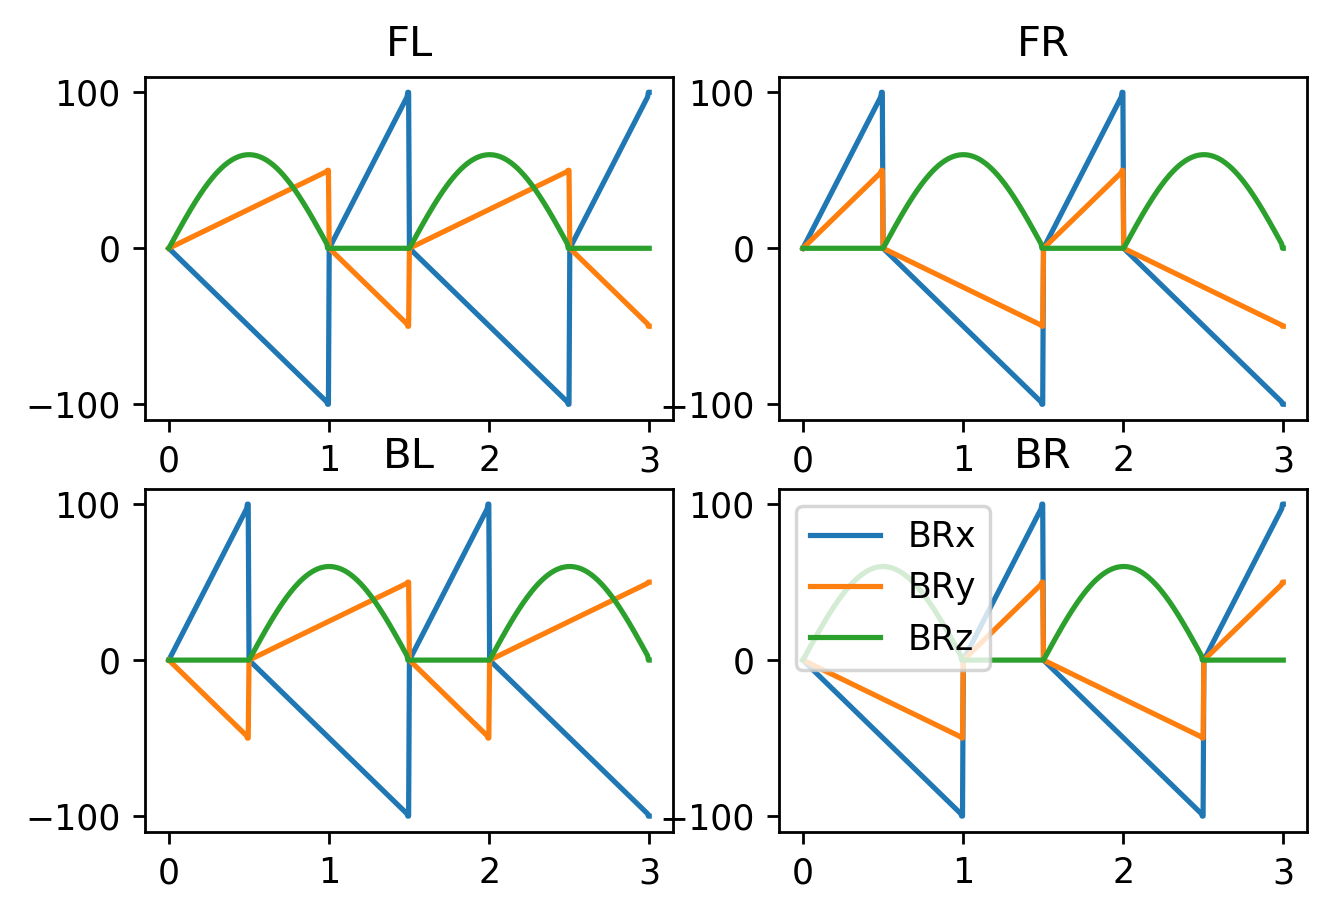

In [34]:
g.trot_gait_debug(3)

In [19]:
t = time.time()
dt = time.time() - t
i = 0
traj = []
while dt <= cmd.gait.cycle_time - cmd.gait.swing_time:
    if dt >= g.sample_time*i:
        i+=1
        traj.append(np.array(g.stance_FR(dt)))

    dt = time.time() - t

In [20]:
traj

[array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0.

In [5]:
import numpy as np
a = np.array([[0,0],[1,1],[2,2], [3,3],[4,4]])
a[::2, :] = [10, 10]
a

array([[10, 10],
       [ 1,  1],
       [10, 10],
       [ 3,  3],
       [10, 10]])

In [6]:
a[1::2,:] = [20,20]
a

array([[10, 10],
       [20, 20],
       [10, 10],
       [20, 20],
       [10, 10]])